In [54]:
import numpy as np 
import matplotlib.pyplot as plt 

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli 
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver, SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA 
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler 
from qiskit.visualization import plot_histogram

import datetime

El variational quantum eigensolver (VQE) es un algoritmo hibrido clásico-cuántico originalmente propuesto para encontrar estados de mínima energía de átomos y moleculas. Sin embargo, también podemos utilizarlo para resolver __problemas combinatoriales__. Acá veremos como aplicar el VQE al __problema del portafolio__.

Consideremos un conjunto $\{x_i\}$ de $n$ acciones en las que podríamos invertir. Sean $\mu_i$ y $\sigma_{ij}$ sus correspondientes retornos experados y covarianza, y sean $q\geq0$ el riesgo dispuesto a asumir y $B$ la billetera, es decir el número de acciones en las que podemos invertir. La estrategia de inversión que nos de el máximo retorno puede encontrarse resolviendo el siguiente problema de optimización,
\begin{equation}
\begin{split}
\min_{\{x_i\}}&\quad q\sum_{ij}\sigma_{ij}x_ix_j - \sum_i \mu_i x_i.\\
& {\rm subj:} \sum_i x_i = B. 
\end{split}
\end{equation}
Podemos resolver este problema de optimización con el VQE mapeandolo a un Hamiltoniano. Esto se realiza haciendo el cambio de variable
\begin{equation}
    x_i \rightarrow \frac{1}{2}(I-Z_i),
\end{equation}
donde $Z_i$ es la matrix de Pauli Z del qubit $i$-ésimo.

__Desafio 1:__ Complete la siguiente función que cree el operador asociado con $x_i$.

In [55]:
def asset_operator( qubit, num_assets ):

    Op = SparsePauliOp( [ Pauli(num_assets*'I')], [0] ) ## Esta es solo una opción por defecto

    ####################################
    z = np.zeros(num_assets)
    x = np.zeros(num_assets)
    z[qubit] = 1
    Op = SparsePauliOp( [ Pauli(num_assets*'I'),Pauli((z,x))], [0.5,-0.5] )
    #####################################

    return Op 

Construyamos un portafolio con $n=4$ acciones aleatorias. Los retornos esperados $\mu_i$ y las covarianzas $\sigma_{ij}$ estan codificados en las variables ``mu`` y ``sigma``, respectivamente.

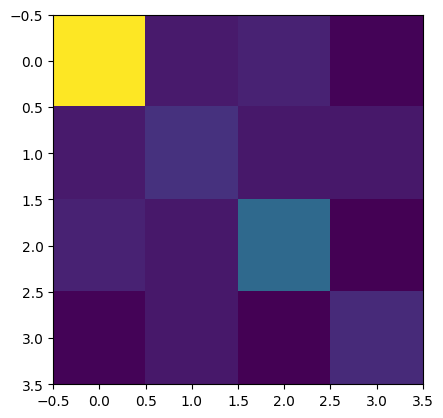

In [56]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

__Desafio 2:__ Consideremos que tenemos una billereta $B=2$ y un riesgo $q=0.5$. Construya el Hamiltoniano asociado a la función objetivo,
\begin{equation}
    H_{\rm fun} = q\sum_{ij}\sigma_{ij}\frac{(I-Z_i)}{2}\frac{(I-Z_j)}{2} - \sum_i \mu_i \frac{(I-z_i)}{2}.
\end{equation}
Codifique este Hamiltoniano en el operador de qiskit ``H_fun``.

In [57]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget

H_fun = SparsePauliOp( num_assets*'I', 0 )

#######################
for i in range(num_assets):
    Op1 = asset_operator( i, num_assets )
    H_fun = H_fun - mu[i]*Op1
    for j in range(num_assets):
        Op2 = asset_operator( j, num_assets )
        H_fun = H_fun + q*sigma[i,j]*Op1@Op2 
######################

__Desafio 3:__ La restricción del problema de optimización puede incluirse en la función objetivo como un penalti de la siguiente forma,
\begin{equation}
    g(\{x_i\})= \sum_i x_i - B.
\end{equation}
Construya el Hamiltoniano $$H_{\rm con}=\sum_i\frac{(I-Z_i)}{2}-B,$$ asociado a la función $g(\{x_i\})$. Codifique este Hamiltoniano en el operador de qiskit ``H_con``.

In [59]:
p = num_assets
H_con = SparsePauliOp( num_assets*'I', 0 ) # Esto es solo una opción por defecto

#####################
H_con = SparsePauliOp( num_assets*'I', -budget )
for i in range(num_assets):
    Op1 = asset_operator( i, num_assets )
    H_con = H_con + Op1 

H_con = H_con @ H_con 
#####################

El Hamiltoniano total es dado por $H = H_{\rm fun} + H_{\rm con}$.

In [60]:
H = H_fun + H_con 
H = H.simplify()
H 

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[ 9.93020582e-01+0.j,  6.98131079e-03+0.j, -4.97829400e-04+0.j,
  5.00018351e-01+0.j,  4.66451258e-05+0.j,  5.00032150e-01+0.j,
  4.30346516e-04+0.j,  4.99975035e-01+0.j,  5.00013261e-01+0.j,
  5.00011120e-01+0.j,  4.99969028e-01+0.j])

In [61]:

def test():
    q = 0.5  # set risk factor
    budget = num_assets // 2  # set budget
    penalty = num_assets  # set parameter to scale the budget penalty term

    portfolio = PortfolioOptimization(
                    expected_returns=mu, 
                    covariances=sigma, 
                    risk_factor=q, 
                    budget=budget
                    )

    qp = portfolio.to_quadratic_program()
    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes)

    result = exact_eigensolver.solve(qp)

    result.x 

    results = NumPyMinimumEigensolver().compute_minimum_eigenvalue( H )
    results.eigenvalue

__Desafio 3:__ A continuación implementamos un VQE para encontrar el mínimo de energía de Hamiltoniano asociado al portafolio. Para encontrar la solución óptima con alta probabilidad necesitamos iniciar la optimización desde el siguiente estado inicial,
\begin{equation}
    |\psi_{\rm in}\rangle = \frac{1}{2\sqrt{2}}\left( |0000\rangle + |0011\rangle + |0101\rangle + |0110\rangle + |1001\rangle + |1010\rangle + |1100\rangle + |1111\rangle  \right).
\end{equation}
Complete el circuito ``initial_state`` para que implemente el estado anterior.

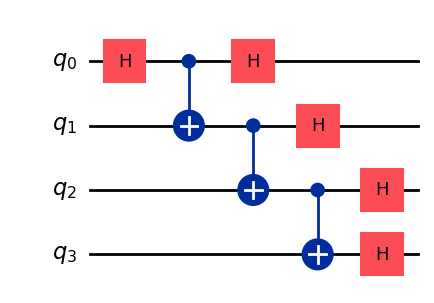

In [62]:
initial_state = QuantumCircuit(num_assets)
################
initial_state.h(0)
for j in range(num_assets-1):
    initial_state.cx(j,j+1)
initial_state.h(range(num_assets))
################
initial_state.draw('mpl') 

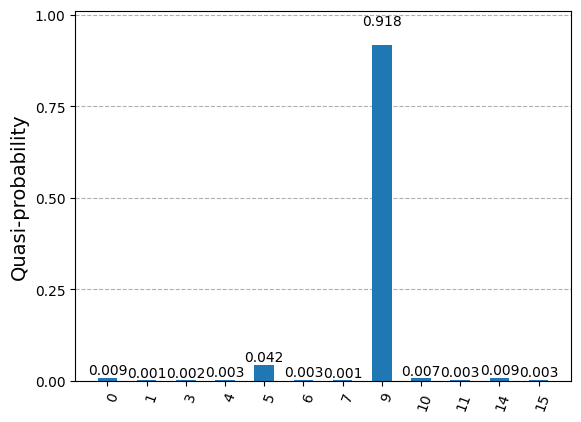

In [63]:
## VQE, no modificar!!!! 
cobyla = COBYLA()

ansatz = TwoLocal(num_assets, 
                    "ry", 
                    "cx", 
                    reps=2, 
                    entanglement="linear", 
                    initial_state=initial_state,
                    )

algorithm_globals.random_seed = 0
svqe_mes = SamplingVQE(sampler=Sampler(run_options={'seed':0}), 
                        ansatz=ansatz, 
                        optimizer=cobyla, 
                        aggregation = 0.9,
                        ) 

results_vqe = svqe_mes.compute_minimum_eigenvalue( H )
plot_histogram( results_vqe.eigenstate ) 

Si el estado inicial fue implementado correctamente debería encontrar la solución 9, correspondiente a la cadena de bits 1001, con una probabilidad superior al 90%.